In [88]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.pyplot import subplots

import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF 
from statsmodels.stats.anova import anova_lm

from ISLP import load_data
from ISLP.models import ModelSpec as MS, summarize, poly

### Problem 8
(a) Summarize the single linear regression:
- There is a linear relationship between 'mpg' and 'horsepower'
- The relationship is strongly negative, indicating by low p_value
- The predicted value for 'horsepower' = 98 is 'mpg' = 24.46
- Confidence interval [23.97, 24.96], while prediction interval [14.80, 34.12]

(b) Plot the regression line

(c) Diagnostic plot
- Residual plot indicates a non-linear pattern
- Many data points have high leverage, causing sensitivity to model

In [2]:
Auto = load_data('Auto')
Auto.head(4)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1


In [24]:
X = pd.DataFrame({'intercept': np.ones(Auto.shape[0]), 'horsepower': Auto['horsepower']})
y = Auto['mpg']
model = sm.OLS(y, X)
result = model.fit()
summarize(result)

,coef,std err,t,P>|t|
intercept,39.9359,0.717,55.660,0.0
horsepower,-0.1578,0.006,-24.489,0.0


In [26]:
X_new = pd.DataFrame({'intercept': 1, 'horsepower': [98]})
y_pred = result.get_prediction(X_new)
print(f'New prediction: {y_pred.predicted_mean}')
print(f'Confidence interval: \n{y_pred.conf_int(alpha=0.05)}')
print(f'Prediction interval: \n{y_pred.conf_int(obs=True, alpha=0.05)}')

New prediction: [24.46707715]
Confidence interval: 
[[23.97307896 24.96107534]]
Prediction interval: 
[[14.80939607 34.12475823]]


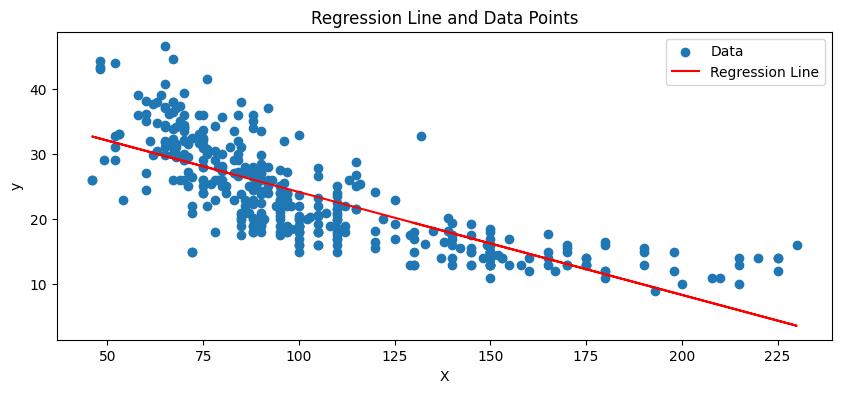

In [44]:
data = pd.DataFrame({'X': X['horsepower'], 'y': y, 'predictions': predictions})

fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(data['X'], data['y'], label='Data')
ax.plot(data['X'], data['predictions'], label='Regression Line', color='red')

ax.set_title('Regression Line and Data Points')
ax.set_xlabel('X')
ax.set_ylabel('y')
ax.legend()

plt.show()


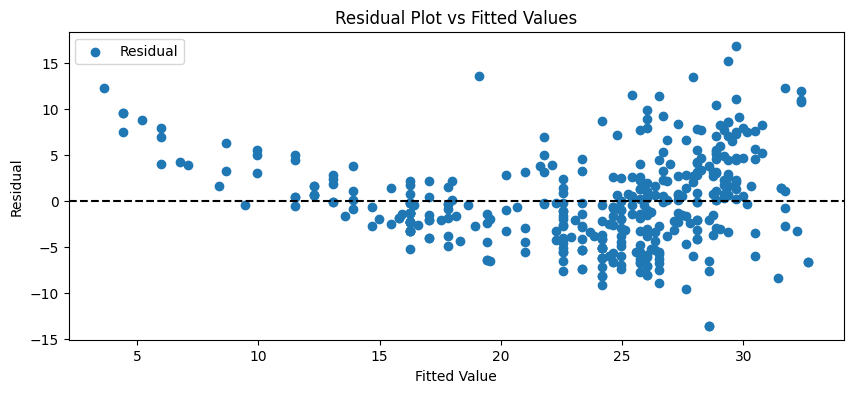

In [46]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.scatter(result.fittedvalues, result.resid, label='Residual')
ax.axhline(y=0, color='black', linestyle='--')

ax.set_title('Residual Plot vs Fitted Values')
ax.set_xlabel('Fitted Value')
ax.set_ylabel('Residual')
ax.legend()

plt.show()

115

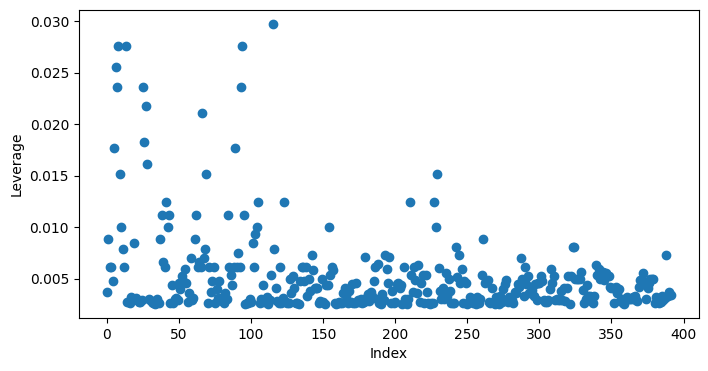

In [39]:
infl = result.get_influence()
ax = subplots(figsize=(8, 4))[1]
ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
np.argmax(infl.hat_matrix_diag)

### Problem 9:

mpg: miles per gallon

cylinders: Number of cylinders between 4 and 8

displacement: Engine displacement (cu. inches)

horsepower: Engine horsepower

weight: Vehicle weight (lbs.)

acceleration: Time to accelerate from 0 to 60 mph (sec.)

year: Model year (modulo 100)

origin: Origin of car (1. American, 2. European, 3. Japanese)

name: Vehicle name

(a) Produce a scatterplot matrix
- All except 'acceleration' seems to have a linear relationship with 'mpg'
- Both of 'displacement', 'horsepower' and 'weight' have skewed distribution
- Categorical features: 'cylinder', 'year', 'origin'

(b) Correlation matrix: some features have collinearity

(c) Perform multiple linear regression:
- Using p_value, 'cylinders', 'horsepower' and 'acceleration' not significant
- Categorical use one baseline, the remaining are additional effects
- Feature engineering: drop 'displacement' and add interaction between horsepower and acceleration
- Final formulation: log(mpg) = -4.2 - 0.02(cylinders) + 0.49(log(horsepower)) - 0.55(log(weight)) + 1.13(log(acceleration)) + 2.31(log(year)) + 0.02(origin) - 0.23(horsepower*acceleration)

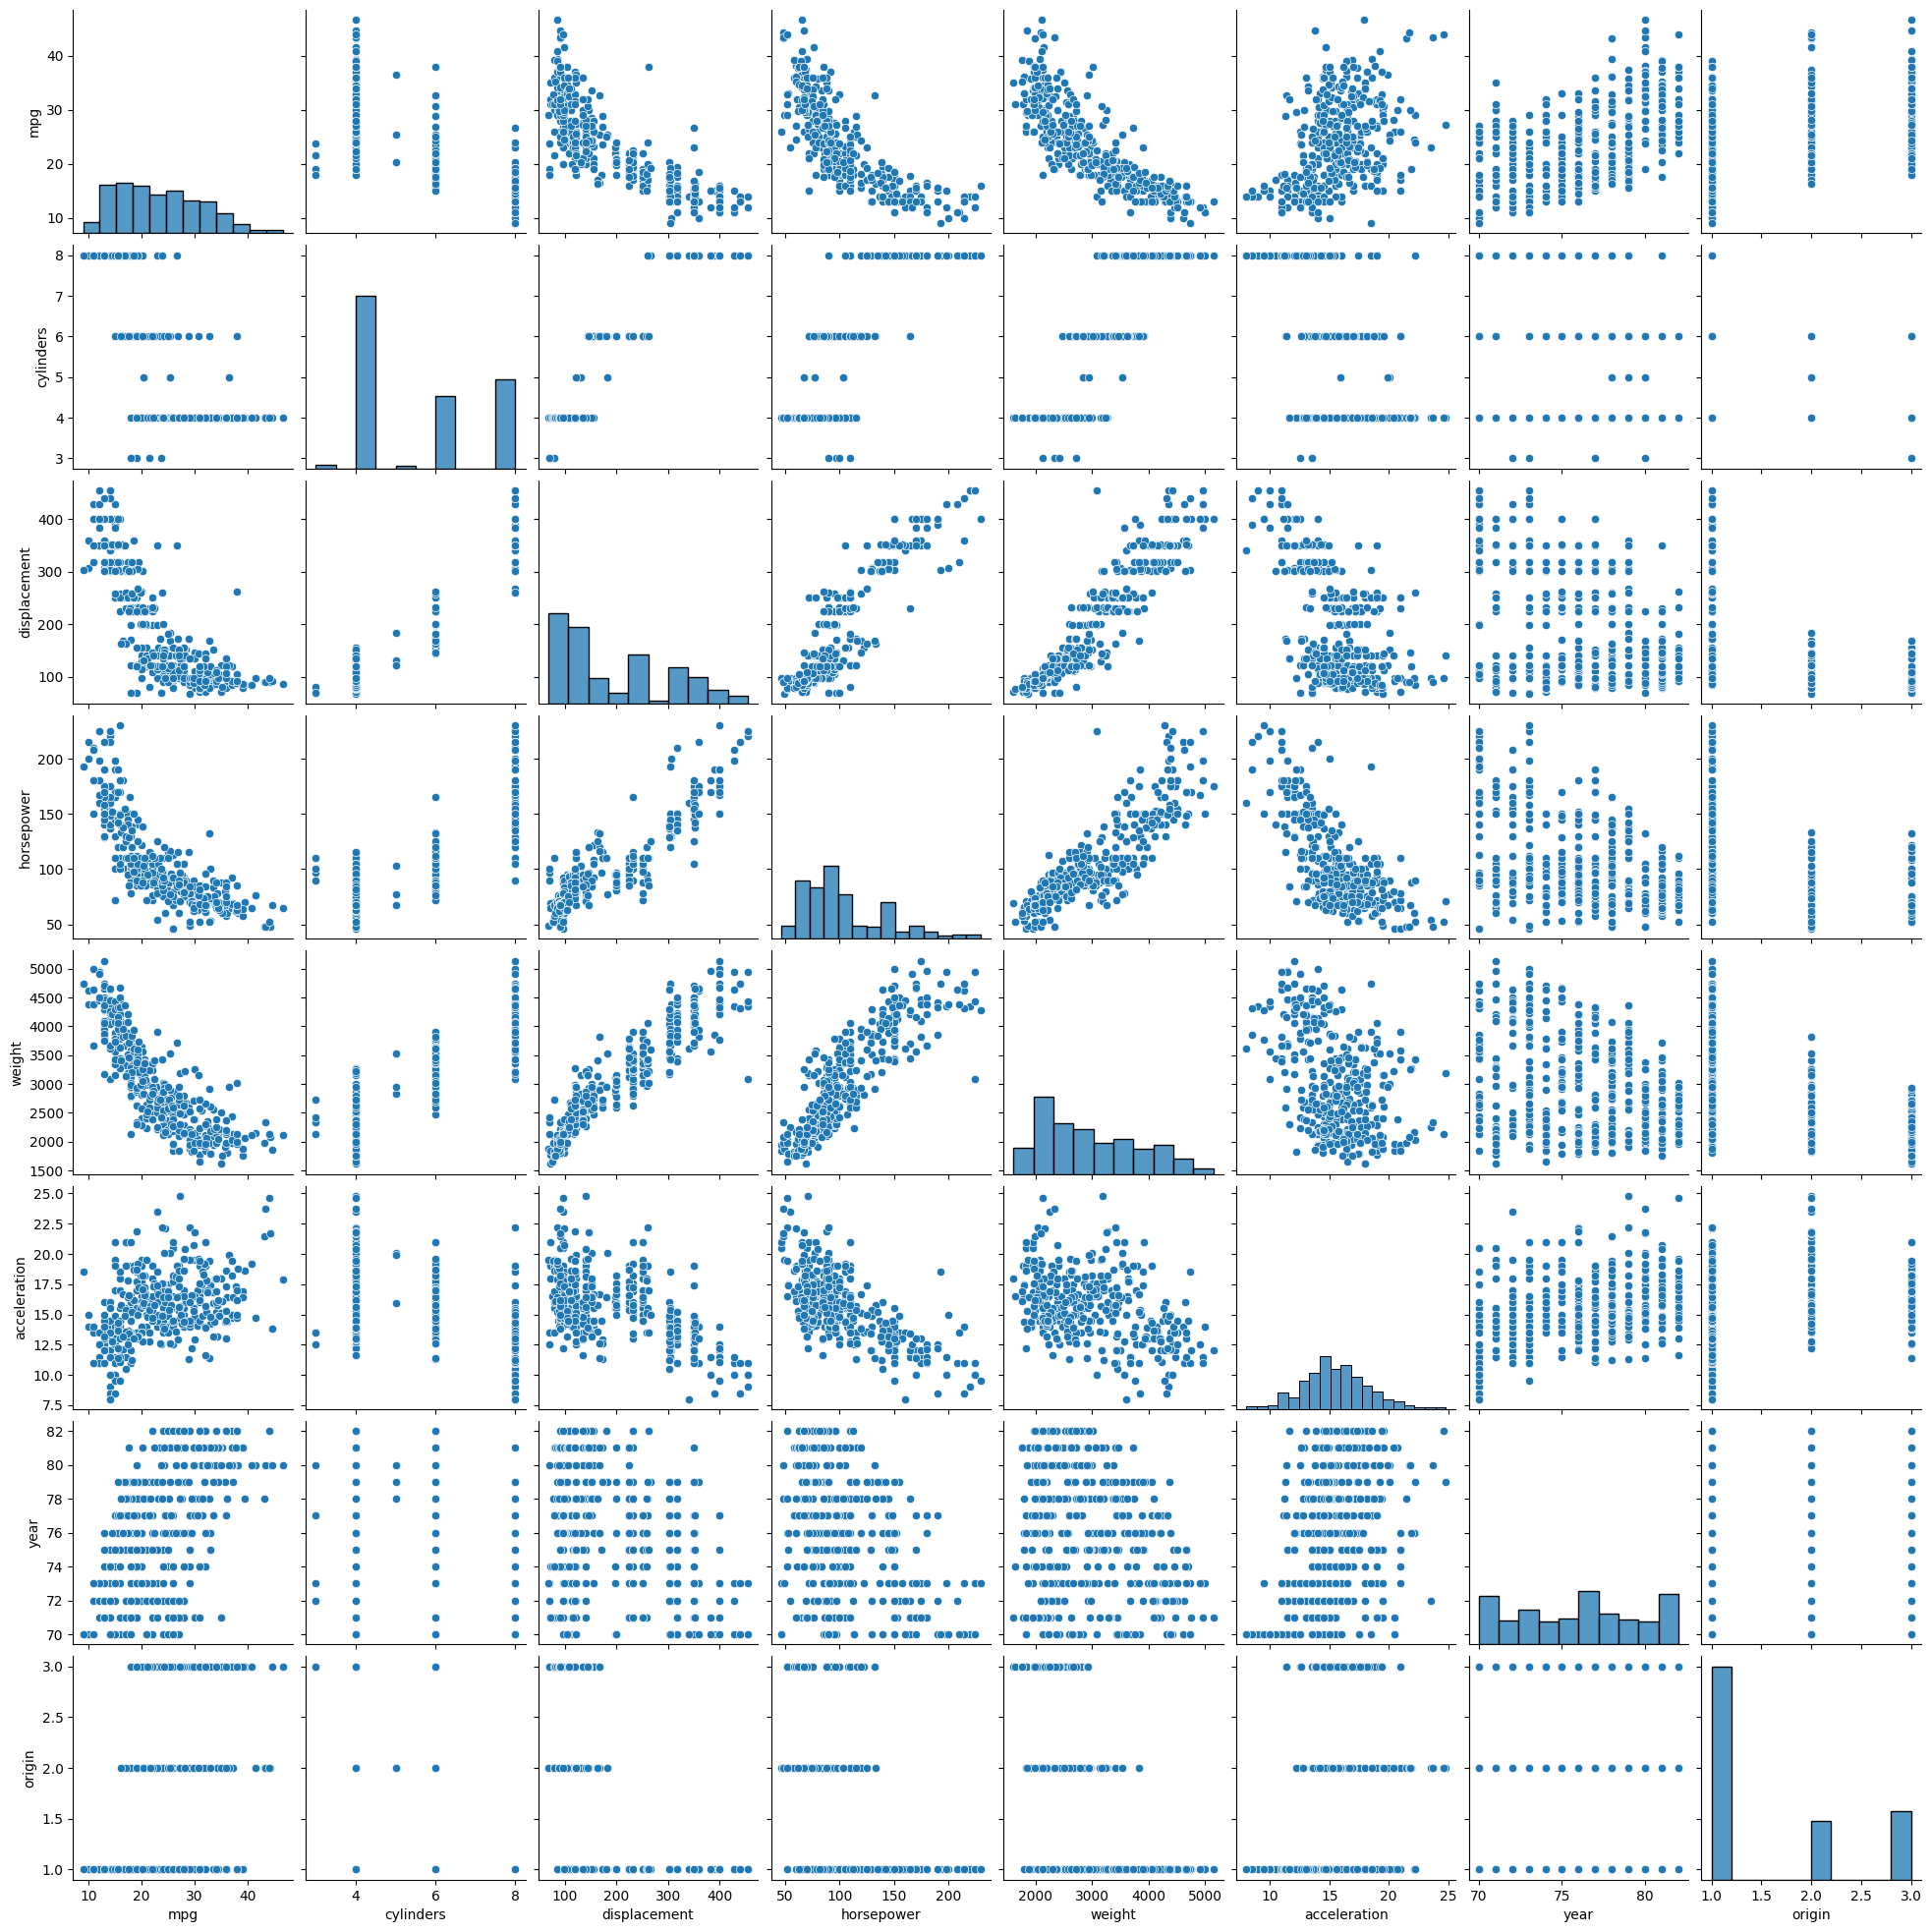

In [13]:
sns.pairplot(Auto)

In [14]:
Auto.corr()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
mpg,1.000000,-0.777618,-0.805127,-0.778427,-0.832244,0.423329,0.580541,0.565209
cylinders,-0.777618,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647,-0.568932
displacement,-0.805127,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855,-0.614535
horsepower,-0.778427,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361,-0.455171
weight,-0.832244,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120,-0.585005
acceleration,0.423329,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316,0.212746
year,0.580541,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000,0.181528
origin,0.565209,-0.568932,-0.614535,-0.455171,-0.585005,0.212746,0.181528,1.000000


In [97]:
X = Auto.drop(columns=['mpg', 'displacement'])

X = sm.add_constant(X)
X['horsepower'] = np.log(X['horsepower'])
X['acceleration'] = np.log(X['acceleration'])
X['year'] = np.log(X['year'])
X['weight'] = np.log(X['weight'])

X['horsepower:acceleration'] = X['horsepower'] * X['acceleration']

y = np.log(Auto['mpg'])

model = sm.OLS(y, X)
result2 = model.fit()

print(result2.rsquared_adj)
print(summarize(result2))

0.8917994439008352
                           coef  std err       t  P>|t|
const                   -4.2081    1.284  -3.278  0.001
cylinders               -0.0214    0.008  -2.696  0.007
horsepower               0.4944    0.226   2.189  0.029
weight                  -0.5592    0.067  -8.385  0.000
acceleration             1.1392    0.372   3.061  0.002
year                     2.3116    0.132  17.577  0.000
origin                   0.0201    0.009   2.220  0.027
horsepower:acceleration -0.2839    0.079  -3.602  0.000


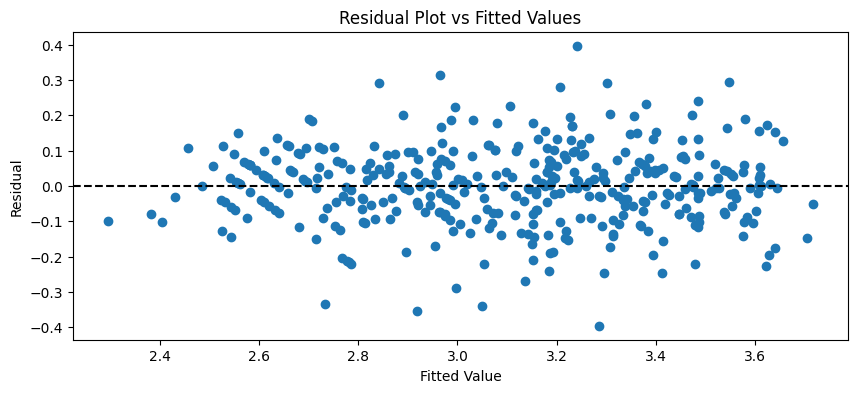

In [98]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.scatter(result2.fittedvalues, result2.resid, label='Residual')
ax.axhline(y=0, color='black', linestyle='--')

ax.set_title('Residual Plot vs Fitted Values')
ax.set_xlabel('Fitted Value')
ax.set_ylabel('Residual')

plt.show()

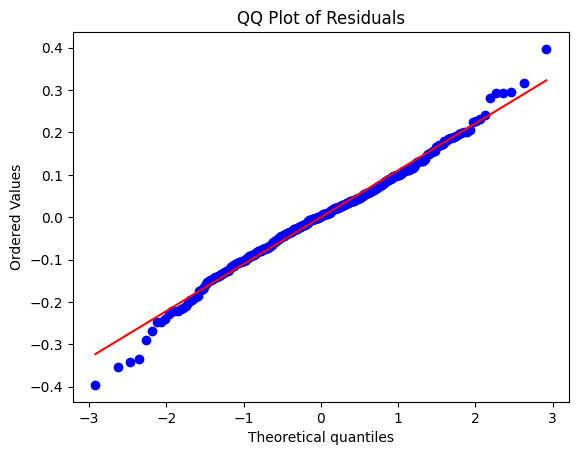

In [99]:
fig, ax = plt.subplots()
stats.probplot(result2.resid, dist="norm", plot=ax)
ax.set_title('QQ Plot of Residuals')
plt.show()

13

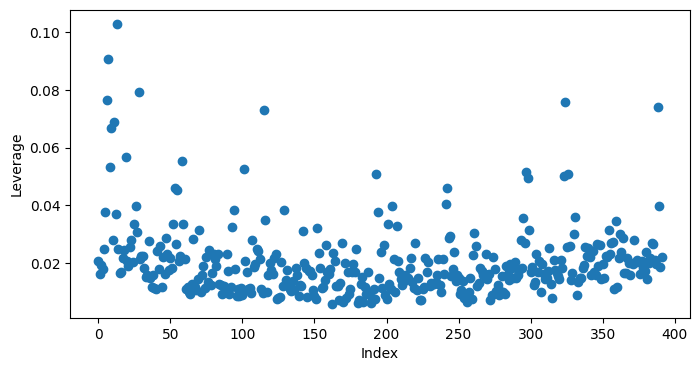

In [100]:
infl = result2.get_influence()
ax = subplots(figsize=(8, 4))[1]
ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
np.argmax(infl.hat_matrix_diag)